<a href="https://colab.research.google.com/github/WoobeenJeong/bioinfo1_jwb/blob/main/Project_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Data mounting**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2) Environment setting**

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

In [ ]:
!conda install -y bedtools bioawk samtools

**3) Data loading & check**

In [4]:
%cd /content/drive/MyDrive/binfo1-work

/content/drive/MyDrive/binfo1-work


In [ ]:
!ls -al /content/drive/MyDrive/binfo1-work/

In [ ]:
!md5sum /content/drive/MyDrive/binfo1-work/*

**4) Background setting**

In [5]:
%cd /content/drive/MyDrive/binfo1-work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

/content/drive/MyDrive/binfo1-work


**5) Target region on CLIP-seq using gencode.gtf**

먼저 GTF파일은 genecode로부터 M32버전이 (2023.02월에) 나왔으며  
M32(GRCm39) Refseq 자료 중 chr9에 대해 확인 할 것  
NCBI RefSeq에서도 Mus musculus strain C57BL/6J chromosome 9, GRCm39 존재

1) C=Shannon’s entrophy를 CRES: Crosslinking-induced reverse transcription error score로 가져감  
2) 이때, insertion은 무시 substitution과 deletion고려  
3) FDR은 permutation으로 구함   
4) Read는 rRNA,tRNA,adapte제외하고 GSNAP의 Refseq에 align  
5) 이를 바탕으로, 먼저 CRES(0.8) 상 low depth positio이 130 reads 이하  
6) LOESS smoothing (regression) a=0.5사용 medium depth positon 250 read이하  
7) FDR(0.001)상 high depth position >250 read 사용  

In [6]:
!gzip -d gencode.vM32.annotation.gtf.gz

gzip: gencode.vM32.annotation.gtf.gz: No such file or directory


In [ ]:
!grep 'chr9' gencode.vM32.annotation.gtf > gencode.vM32.chr9.gtf

In [ ]:
!head gencode.vM32.chr9.gtf

In [ ]:
!awk -F'\t' '{if ($3 == "gene") print $4}' gencode.vM32.chr9.gtf | sort -n | head -n 1
!awk -F'\t' '{if ($3 == "gene") print $5}' gencode.vM32.chr9.gtf | sort -n | tail -n 1

3038669
124252776


In [11]:
!samtools view -b -o CLIP-let7g.bam CLIP-35L33G.bam chr9:3038669-124252776
!samtools view CLIP-let7g.bam | wc -l

1696165


In [27]:
!samtools index CLIP-let7g.bam

In [29]:
!samtools view -F 16 CLIP-let7g.bam | wc -l

905001


In [34]:
!samtools view -b -F 0x10 -o forward-CLIP-let7g.bam CLIP-let7g.bam

In [35]:
!samtools view -f 16 forward-CLIP-let7g.bam  | wc -l

0


In [37]:
!samtools view -F 16 forward-CLIP-let7g.bam  | wc -l

905001


In [38]:
!samtools mpileup forward-CLIP-let7g.bam 2>/dev/null > forward-CLIP-let7g.pileup
!wc -l forward-CLIP-let7g.pileup

19118539 forward-CLIP-let7g.pileup


In [39]:
!awk '$2 >= 3038669 && $2 <= 124252714 { print $0; }' forward-CLIP-let7g.pileup > forward-CLIP-let7g-gene.pileup
!tail -n 2 forward-CLIP-let7g-gene.pileup

chr9	124238768	N	4	CCCC	3IHH
chr9	124238769	N	4	A$A$A$A$	8HHH


In [40]:
pileup = pd.read_csv('forward-CLIP-let7g-gene.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
pileup.tail()

,chrom,pos,_ref,count,basereads,quals
19118534,chr9,124238765,N,4,TTTT,7IHH
19118535,chr9,124238766,N,4,GGGG,5IHH
19118536,chr9,124238767,N,4,TTTT,4IHH
19118537,chr9,124238768,N,4,CCCC,3IHH
19118538,chr9,124238769,N,4,A$A$A$A$,8HHH


In [ ]:
count의 개수가 최대 / 최소 얼마이고 볼 만한 수준인지 확인

In [41]:
len(np.unique(pileup['count']))

1825

In [42]:
pileup['count'].describe()

count    1.911854e+07
mean     1.057442e+01
std      4.906052e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      7.983000e+03
Name: count, dtype: float64

In [43]:
np.max(pileup['count'])

7983

위를 보면 알수 있듯이 한 75%까지는 10개정도만 count되어 있는데, 무려 7983 read가 count되는 경우도 있음.  
이경우는 좀 궁금하긴 하다만, 너무 크기 때문에, threshold <=130 reads로 두고 진행   
(Shannon에서 depth 50으로 했으므로)

In [54]:
f50pileup = pileup[pileup['count'] > 50]

In [55]:
len(np.unique(f50pileup['count']))

1774

In [56]:
len(np.unique(f50pileup['pos']))

544430

In [57]:
f50pileup['count'].describe()

count    544430.000000
mean        141.617628
std         254.523936
min          51.000000
25%          58.000000
50%          72.000000
75%         108.000000
max        7983.000000
Name: count, dtype: float64

In [58]:
max(f50pileup['pos']),max(f50pileup['pos'])-min(f50pileup['pos'])

(123421315, 120061773)

match와 substitution, deletion을 사용할 것이므로, 나머지에 해당하는 tag들은 제거.  
**여기서 Deletion은 포함하는 경우를 고려하는 것을 고민할 것**

In [65]:
toremove = re.compile(r'[<>$*#+-]|\^.')
f50pileup.loc[:, 'matches'] = f50pileup['basereads'].apply(lambda x: toremove.sub('', x))

<ipython-input-65-854502dbb2ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f50pileup.loc[:, 'matches'] = f50pileup['basereads'].apply(lambda x: toremove.sub('', x))


In [66]:
f50pileup[['chrom', 'pos', 'matches']].head()

,chrom,pos,matches
21659,chr9,3359542,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21660,chr9,3359543,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21661,chr9,3359544,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
21662,chr9,3359545,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21663,chr9,3359546,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...


Deletion상관 없이 Insertion하고 Hard-clipped read만 제외

In [ ]:
#f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c != 'H' and c != 'I']))
#f50pileup.head()

In [67]:
f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c.upper() in ('A', 'T', 'G', 'C', 'D')]))
f50pileup.head()

<ipython-input-67-65db69172171>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c.upper() in ('A', 'T', 'G', 'C', 'D')]))


,chrom,pos,_ref,count,basereads,quals,matches,base_count
21659,chr9,3359542,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,HDEIHIIGIIIHHIIGAIIIGIBGIHBFGIHE?GIGIHGGHHIBII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21660,chr9,3359543,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IGEIHFG@IIIHHHIGFHIIEIBHIH;GGIHH=GIEIHIGHHIGII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21661,chr9,3359544,N,51,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHBIHIIDHGIGHIIIDIIIDH0HH?DEHFHBBGIGIHIGHHDAII...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,51
21662,chr9,3359545,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IH8IHIIEIGIGHIIFFIIIGI=HIHDGGIHI;GHIIGHGHHI4DI...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21663,chr9,3359546,N,51,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,IHEIHHIEIGGDHIIDHIIIGI7HIH>GHIHI<GIGIFIGDHFCII...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,51


In [68]:
np.unique(f50pileup['matches'])

array(['', 'A', 'A1GA1GA1GA1GA1GA1GA1GA1G', ...,
       'TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT

In [69]:
np.unique(f50pileup['base_count'])

array([   0,    1,    2, ..., 7973, 7975, 7977])

Colab RAM사용 제한 상, 데이터가 날라가는 것을 방지하기 위해 일단 결과 csv 저장

In [70]:
f50pileup.to_csv('f50pileup.csv', index=True)

RAM 사용량 상, 작업을 다른 주피터 노트북에 작성

In [71]:
f50pileup.head()

,chrom,pos,_ref,count,basereads,quals,matches,base_count
21659,chr9,3359542,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,HDEIHIIGIIIHHIIGAIIIGIBGIHBFGIHE?GIGIHGGHHIBII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21660,chr9,3359543,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IGEIHFG@IIIHHHIGFHIIEIBHIH;GGIHH=GIEIHIGHHIGII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21661,chr9,3359544,N,51,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHBIHIIDHGIGHIIIDIIIDH0HH?DEHFHBBGIGIHIGHHDAII...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,51
21662,chr9,3359545,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IH8IHIIEIGIGHIIFFIIIGI=HIHDGGIHI;GHIIGHGHHI4DI...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21663,chr9,3359546,N,51,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,IHEIHHIEIGGDHIIDHIIIGI7HIH>GHIHI<GIGIFIGDHFCII...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,51


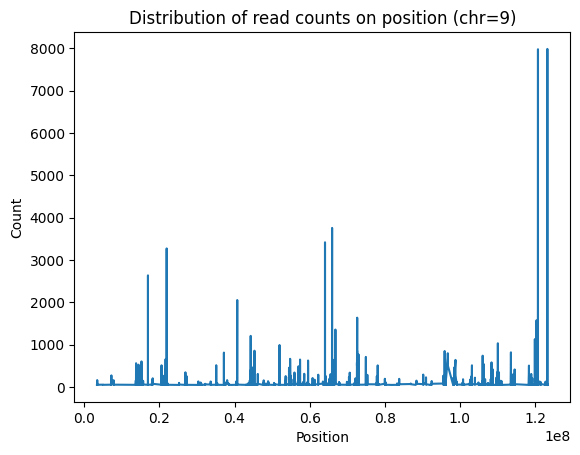

In [72]:
x = f50pileup['pos']
y = f50pileup['count']

plt.plot(x, y)
plt.xlabel('Position')
plt.ylabel('Count')
plt.title('Distribution of read counts on position (chr=9)')
plt.show()

In [73]:
np.unique(f50pileup['base_count'])

array([   0,    1,    2, ..., 7973, 7975, 7977])

In [109]:
pup = f50pileup[f50pileup['base_count']>250]

In [110]:
pup['nonzero'] = pup['base_count']/pup['matches'].apply(len)
pup.head()

<ipython-input-110-700d9518f8b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup['nonzero'] = pup['base_count']/pup['matches'].apply(len)


,chrom,pos,_ref,count,basereads,quals,matches,base_count,nonzero
419317,chr9,7206915,N,266,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,HDGI/GHHHIIIGHHEII@EIIGIIIIIIHHIHIIIGHDHI8GIGG...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,266,1.0
419318,chr9,7206916,N,267,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,HHBI=BIHGIIHGHHEIIGFIIGIIIIIIHGIFIIIH@GHIEGEGG...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,267,1.0
419319,chr9,7206917,N,273,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,HHGI;EFHHGHH@HHGHIGGIIDIIIFIHHGIEIIIGGDGIDGDGG...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,273,1.0
419320,chr9,7206918,N,273,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,HHFI>IIHGIIIBGHDIIGGIIGIIIIIHHGIGIIHGE@HIGGEGG...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,273,1.0
419321,chr9,7206919,N,273,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,BHGG=HIHGIII?GFGIIGEHIDIIIHIIHGHGHIIGEBGIGGGEE...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,273,1.0


In [111]:
pup['shannon'] = -pup['nonzero']*np.log2(pup['nonzero'])
pup.head()

<ipython-input-111-95ec17a8bda6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup['shannon'] = -pup['nonzero']*np.log2(pup['nonzero'])


,chrom,pos,_ref,count,basereads,quals,matches,base_count,nonzero,shannon
419317,chr9,7206915,N,266,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,HDGI/GHHHIIIGHHEII@EIIGIIIIIIHHIHIIIGHDHI8GIGG...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,266,1.0,-0.0
419318,chr9,7206916,N,267,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,HHBI=BIHGIIHGHHEIIGFIIGIIIIIIHGIFIIIH@GHIEGEGG...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,267,1.0,-0.0
419319,chr9,7206917,N,273,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,HHGI;EFHHGHH@HHGHIGGIIDIIIFIHHGIEIIIGGDGIDGDGG...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,273,1.0,-0.0
419320,chr9,7206918,N,273,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,HHFI>IIHGIIIBGHDIIGGIIGIIIIIHHGIGIIHGE@HIGGEGG...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,273,1.0,-0.0
419321,chr9,7206919,N,273,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,BHGG=HIHGIII?GFGIIGEHIDIIIHIIHGHGHIIGEBGIGGGEE...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,273,1.0,-0.0


In [112]:
pup['shannon'].describe()

count    6480.000000
mean        0.008396
std         0.031797
min        -0.000000
25%        -0.000000
50%        -0.000000
75%         0.000000
max         0.436626
Name: shannon, dtype: float64

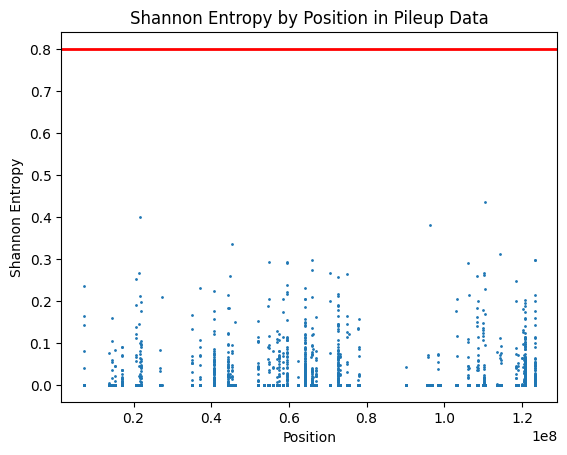

In [113]:
plt.scatter(pup['pos'], pup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.axhline(0.8, c='red', linewidth=2)
plt.show()

In [101]:
import collections
 
from scipy.stats import entropy
  
def estimate_shannon_entropy(dna_sequence):
    bases = collections.Counter([tmp_base for tmp_base in dna_sequence])
    # define distribution
    dist = [x/sum(bases.values()) for x in bases.values()]
 
    # use scipy to calculate entropy
    entropy_value = entropy(dist, base=2)
 
    return entropy_value

In [106]:
pup2 = pup

In [107]:
pup2['shannon'] = pup2['matches'].map(lambda x : estimate_shannon_entropy(x))

<ipython-input-107-6f2a8a707f67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup2['shannon'] = pup2['matches'].map(lambda x : estimate_shannon_entropy(x))


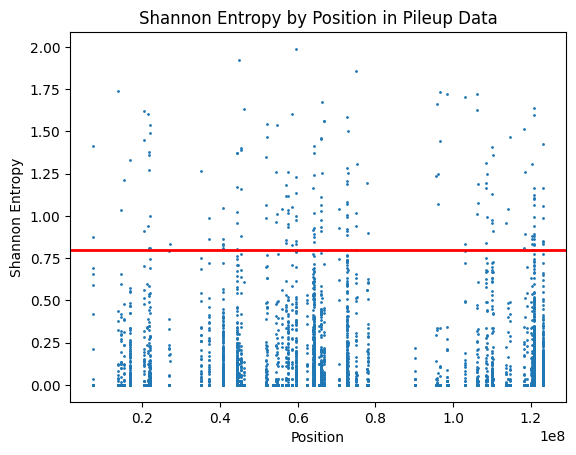

In [108]:
plt.scatter(pup2['pos'], pup2['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.axhline(0.8, c='red', linewidth=2)
plt.show()